In [28]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import warnings
#import models
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score


In [33]:
#Andrew fixed up the training data set, so use that for new training set
newtrain = pd.read_csv("/Users/triciangoon/Math189-Predicting-Housing-Prices/Math189-Predicting-Housing-Prices/new_training_data.csv")
no_dummies = pd.read_csv("/Users/triciangoon/Math189-Predicting-Housing-Prices/Math189-Predicting-Housing-Prices/no_dummies.csv")
targets = newtrain['SalePrice']
no_dummies = no_dummies.drop('SalePrice',1)
newtrain = newtrain.drop('SalePrice', 1)
newtrain = pd.get_dummies(newtrain)
#newtrain.head()

In [30]:
# outliers = newtrain[newtrain['GrLivArea'] > 4500]
# outliers.describe()
# outliers_index = newtrain[newtrain['GrLivArea'] > 4500].index
# newtrain = newtrain.drop(newtrain.index[[outliers_index]])

In [34]:
numerical_features = [key for key in dict(no_dummies.dtypes) if dict(no_dummies.dtypes)[key] in ['float64', 'int64']]
skewed_features = []
for feature in numerical_features:
    if abs(no_dummies[feature].skew()) > .8:
        skewed_features.append(feature)

In [35]:
skewed_features

['3SsnPorch',
 'BsmtUnfSF',
 '2ndFlrSF',
 'LotArea',
 'GrLivArea',
 'MasVnrArea',
 'LotFrontage',
 'MiscVal',
 'KitchenAbvGr',
 'BsmtHalfBath',
 'BsmtFinSF2',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'MSSubClass',
 'WoodDeckSF',
 '1stFlrSF',
 'LowQualFinSF',
 'EnclosedPorch']

In [36]:
newtrain = newtrain.copy()
for feature in skewed_features:
    newtrain[feature] = np.log1p(newtrain[feature])

In [37]:
#log transform of data
targets = np.log1p(targets)

In [54]:
#run PCA
pca = PCA(whiten=True)
pca.fit(newtrain,targets)
#variance to determine # of components
var = pca.explained_variance_ratio_
#cumulative variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
print cumvar
pcadata = pca.transform(newtrain)

[ 0.46926919  0.77308848  0.94156507  0.99739099  0.99925846  0.99964538
  0.99989044  0.99991046  0.99992304  0.99993339  0.99994279  0.99994942
  0.99995513  0.99995949  0.99996276  0.99996574  0.99996867  0.99997135
  0.99997358  0.99997519  0.99997662  0.99997778  0.99997876  0.99997964
  0.99998046  0.99998121  0.99998191  0.99998261  0.9999832   0.99998374
  0.99998423  0.99998472  0.99998519  0.99998565  0.99998609  0.9999865
  0.9999869   0.99998729  0.99998767  0.99998803  0.99998839  0.99998872
  0.99998905  0.99998937  0.99998968  0.99998997  0.99999025  0.99999053
  0.9999908   0.99999107  0.99999132  0.99999156  0.99999179  0.99999202
  0.99999223  0.99999245  0.99999266  0.99999286  0.99999305  0.99999324
  0.99999342  0.9999936   0.99999377  0.99999394  0.99999409  0.99999425
  0.9999944   0.99999455  0.99999469  0.99999483  0.99999497  0.9999951
  0.99999524  0.99999536  0.99999549  0.99999561  0.99999573  0.99999584
  0.99999595  0.99999605  0.99999615  0.99999625  0.9

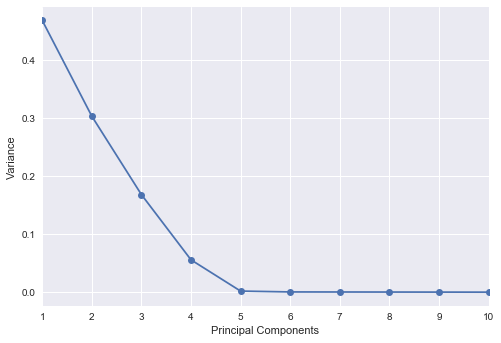

In [59]:
varr = pd.DataFrame(pca.explained_variance_ratio_)
plt.xlim(1,10)
plt.xlabel("Principal Components")
plt.ylabel("Variance")
plt.plot(range(1,303),varr,marker='o')
plt.show()

In [73]:
#5 components, features up until variance =>.99
pca = PCA(n_components=20, whiten=True)
pca = pca.fit(newtrain)
pcadata = pca.transform(newtrain)
print pcadata

[[ 0.21062867 -1.7063869  -0.99737894 ...,  0.01668978 -0.27433727
   0.43566786]
 [ 1.06457459 -1.66191006 -0.7863562  ...,  0.86606859 -0.73493184
  -2.33152415]
 [ 0.01663799 -1.71759883 -0.32689736 ..., -0.31087143  0.298552
  -0.00368997]
 ..., 
 [-0.24943618  1.70037427  0.46173275 ...,  3.64157175  3.06228488
  -1.9971592 ]
 [-0.65550895  1.6754658   0.79939673 ..., -1.69474706  1.28457665
   0.21635179]
 [ 0.64756291  1.76830495 -0.53761556 ...,  0.19717443 -1.20094742
   0.3451132 ]]


In [74]:
#test models
def NormRMSE(observed, predicted):
    return np.sqrt(((predicted - observed)**2).mean())

def CV(data,targets,model,k):
    RMSE = []
    kf = KFold(n_splits=k, shuffle=True)
    X = data.copy()

    y = targets
    #X = X.values

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_predictions = model.predict(X_test)

    RMSE.append(NormRMSE(y_test, y_predictions))
    return np.mean(RMSE)

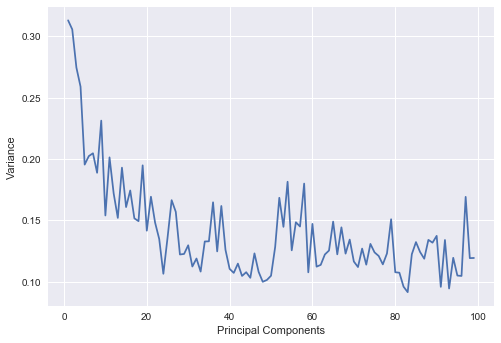

In [72]:
errors = []
for i in range(1,100):
    pca = PCA(n_components=i, whiten=True)
    pca = pca.fit(newtrain)
    pcadata = pca.transform(newtrain)
    errors.append(CV(pcadata,targets,Lin_reg,20))
plt.plot(range(1,100),errors)
plt.xlabel("Principal Components")
plt.ylabel("Variance")
plt.savefig('pca_erros.png')
plt.show()


In [75]:
#test models
Lin_reg = linear_model.LinearRegression()
Rid_reg = linear_model.RidgeCV()
Lass = linear_model.LassoCV(alphas = [ .001*i for i in range(1,2000)])

In [77]:
#leave-one-out cross validation
RMSE = CV(pcadata,targets,Lin_reg,len(pcadata))
print(RMSE)

RMSE = CV(pcadata,targets,Rid_reg,len(pcadata))
print(RMSE)

RMSE = CV(pcadata,targets,Lass,len(pcadata))
print(RMSE)

0.00667084684324
0.110808616894
0.224310843215


In [76]:
#5 k-folds
RMSE = CV(pcadata,targets,Lin_reg,5)
print(RMSE)

RMSE = CV(pcadata,targets,Rid_reg,5)
print(RMSE)

RMSE = CV(pcadata,targets,Lass,5)
print(RMSE)

0.134277910386
0.128227657543
0.137110545673
